**Identifying features that influence low-income student success**

by Ben Lacar
<br>
October 2019


## Introduction

I investigated features of high schools that promote the college eligibility rates of low-income students. The hope is to identify features that can be affected by policy changes to help low income students graduate and become college eligible at a higher rate. I focused on CA public high schools.

To obtain features of schools that could be meaningful for my target, I pulled in data from various sources. I obtained census data for each zip code in the state of CA. I then pulled in information from the CA public schools database. Finally, I used data from GreatSchools both with an API and with custom functions (example of one high school shown [here](https://www.greatschools.org/california/chula-vista/6279-Bonita-Vista-Senior-High-School/#Low-income_students*Graduation_rates*UC_CSU_eligibility)).

In [1]:
# Import packages

# Web scraping
import os
import urllib.request
import requests
from io import StringIO
from bs4 import BeautifulSoup
# Use xml package for GreatSchools data
import xml.etree.ElementTree as ET

# Dataframe munging and statistics
import re
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Data visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

# Machine learning
from sklearn.decomposition import PCA

# Machine learning, linear regression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [1146]:
parent_path = '/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study/'
os.chdir(parent_path) 
os.getcwd()

'/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study'

## Data sources
1. Demographic information for CA by zip code (median income, employment status, worker class, education level)
2. School information (public, charter status, magnet status, address)
3. School enrollment and dropout data (by grades for ethnicity, gender)
4. GreatSchools website

### Data source 1: Population data by zip code (factfinder.census.gov)

In [1147]:
df_demo_info = pd.read_csv('data/ACS_15_5YR_DP03_with_ann.csv')
df_demo_info.head()

,Id,Id2,Geography,Estimate; EMPLOYMENT STATUS - Population 16 years and over,Margin of Error; EMPLOYMENT STATUS - Population 16 years and over,Percent; EMPLOYMENT STATUS - Population 16 years and over,Percent Margin of Error; EMPLOYMENT STATUS - Population 16 years and over,Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Margin of Error; EMPLOYMENT STATUS - Population 16 years and over - In labor force,Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force,...,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - People in families,Estimate; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over,Percent Margin of Error; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over - Unrelated individuals 15 years and over
0,8600000US89010,89010,ZCTA5 89010,484,125,484,(X),233,92,48.1,...,19.7,17.5,(X),(X),21.2,16.2,(X),(X),39.1,23.2
1,8600000US89019,89019,ZCTA5 89019,1663,527,1663,(X),852,310,51.2,...,10.1,15,(X),(X),0,2.2,(X),(X),24.9,16.8
2,8600000US89046,89046,ZCTA5 89046,404,136,404,(X),175,96,43.3,...,10.9,13.4,(X),(X),41,34,(X),(X),40.1,20.6
3,8600000US89060,89060,ZCTA5 89060,8136,629,8136,(X),3473,514,42.7,...,10.7,5.1,(X),(X),18.5,6.9,(X),(X),23.9,6.2
4,8600000US89061,89061,ZCTA5 89061,4492,529,4492,(X),1889,340,42.1,...,2.5,3,(X),(X),3.2,3,(X),(X),18.2,11.8


In [7]:
for i in df_demo_info['Id2'].unique():
    df_temp = df_demo_info[df_demo_info['Id2']==i]
    if df_temp.shape[0] > 1:
        df_temp
        break

In [8]:
df_demo_info['Id2'].unique()

array([89010, 89019, 89046, ..., 96155, 96161, 97635])

In [9]:
def import_census_data(csv_file):
    df_demo_info = pd.read_csv('data/ACS_15_5YR_DP03_with_ann.csv')
    df_demo_info.set_index('Id2', inplace=True) # set the zip code as the index value
    
    # Rename demographic information columns to improve readability
    demo_column_names = ({'Estimate': 'Est.',
                      'Percent': '%',
                      'EMPLOYMENT STATUS': 'EMPLOY_STATUS',
                      'Population': 'Pop.',
                      'Margin of Error': 'error_margin',
                      'and over': 'and up',
                      'years':'yrs',
                      'COMMUTING TO WORK': 'WORK_COMMUTE',
                      'CLASS OF WORKER': 'WORKER_CLASS',
                      'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)': 'INCOME_BENEFITS',
                      'HEALTH INSURANCE COVERAGE': 'HEALTH_INS_COVERAGE',
                      '(dollars)': '($)',
                      'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL': '%-AGE_FAMILIES_INCOME_BELOW_POVERTY',
                      '18 to 64': '18-64',
                      'with': 'w/',
                      'With': 'w/',
                      'under 18': '<18',
                      'population': 'pop.',
                      'health insurance coverage': 'health ins coverage'
                     })

    # Replace words in column names
    df_temp = pd.DataFrame()
    df_temp['old_col_names'] = df_demo_info.columns
    df_temp['new_col_names'] = None
    
    for i in range(len(df_temp)):
        string = df_temp.loc[i,'old_col_names']
        for key in demo_column_names:
            string = string.replace(key, demo_column_names[key])
        df_temp.loc[i, 'new_col_names'] = string
    df_demo_info.columns = df_temp['new_col_names']

    # Remove columns that contain "error" since it won't be used in the analysis moving forward.
    mask_col_w_error = df_demo_info.columns.str.contains('error')
    df_demo_info = df_demo_info.copy().loc[:,~mask_col_w_error]

    # Remove columns where most values are (X) 
    mask_of_X = df_demo_info.iloc[:,274]!='(X)'

    mask_of_X = df_demo_info !='(X)'
    samples_w_values = np.sum(mask_of_X)
    mask_columns_samples_wvalues = np.sum(mask_of_X) > 1400

    # Demographic info with values, no errors
    df_demo_info = df_demo_info.copy().loc[:,mask_columns_samples_wvalues]
    
    # Focus on features shown in percentages (other code were things I tried)
    mask_perc = df_demo_info.columns.str.startswith('%')
    #mask_est = df_test.columns.str.startswith('Est.')
    # df_test_only_numbers = df_test.loc[:, (mask_perc + mask_est)].copy()

    # Convert all strings with a dash into NaN
    df_demo_perc_only = df_demo_info.loc[:, mask_perc].copy()

    # Convert all strings with a dash into NaN
    mask_dash = (df_demo_perc_only=='-')  
    mask_x = (df_demo_perc_only=='(X)') 
    df_demo_perc_only[mask_dash | mask_x] = np.nan

    # Convert rest of values from string to floating point
    df_demo_perc_only = df_demo_perc_only.astype('float64', copy=False)
    
    # Identify features where most (90%) of the values are < 100%
    df_temp = pd.DataFrame()
    df_temp['feature'] = None
    df_temp['min'] = None
    df_temp['max'] = None
    df_temp['prop_<100%'] = None

    # Check range of values and determine the proportion less than 100%
    for index, value in enumerate(df_demo_perc_only.columns):
        try:
            df_temp.loc[index, 'feature'] = value
            df_temp.loc[index, ['min', 'max']] = (df_demo_perc_only[value].min(), df_demo_perc_only[value].max())
            # For next line, NaNs are not counted
            df_temp.loc[index, 'prop_<100%'] = sum(df_demo_perc_only[value] <= 100)/len(df_demo_perc_only)
        except:
            continue

    # Get features where most (90%) of the values are < 1 (100%)
    valid_features = df_temp.loc[df_temp['prop_<100%'] >= 0.9, 'feature'].tolist()
    
    # Add the identifying columns back in and include those about income
    income_columns = df_demo_info.columns[df_demo_info.columns.str.contains('income')].tolist()
    
    df_demo_info_perc = pd.merge(df_demo_info[['Id', 'Geography'] + income_columns], df_demo_perc_only[valid_features],
                                  left_index=True, right_index=True)
    
    # Remove rows where 90% of the census info for that zip code is missing
    df_demo_info_final = df_demo_info_perc[df_demo_info_perc.count(axis=1)/df_demo_info_perc.shape[1] >= 0.9]
    
    return df_demo_info_final

In [10]:
df_census = import_census_data('ACS_15_5YR_DP03_with_ann.csv')

#### Broad categories in census columns


In [1165]:
# Census columns that start with '%'
col_census_pct = df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.startswith('%')]
# Broad categories in pct census columns
print(set([i.split('-')[0] for i in col_census_pct.tolist()]))

{'%; INDUSTRY ', '%; WORK_COMMUTE ', '%; OCCUPATION ', '%; WORKER_CLASS ', '%; HEALTH_INS_COVERAGE ', '%; %', '%; EMPLOY_STATUS ', '%; INCOME_BENEFITS '}


In [1166]:
# Census columns that start with 'Est'
col_census_est = df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.startswith('Est')]
col_census_est

Index(['Est.; INCOME_BENEFITS - Total households - Median household income ($)',
       'Est.; INCOME_BENEFITS - Total households - Mean household income ($)',
       'Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)',
       'Est.; INCOME_BENEFITS - w/ retirement income',
       'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
       'Est.; INCOME_BENEFITS - Families - Median family income ($)',
       'Est.; INCOME_BENEFITS - Families - Mean family income ($)',
       'Est.; INCOME_BENEFITS - Per capita income ($)',
       'Est.; INCOME_BENEFITS - Nonfamily households - Median nonfamily income ($)',
       'Est.; INCOME_BENEFITS - Nonfamily households - Mean nonfamily income ($)'],
      dtype='object')

### Data Source 2: School information (public, charter status, magnet, address) 

- Import the school info and extract the 5 digit code for each school district

In [848]:
def import_school_info():
    # url = 'ftp://ftp.cde.ca.gov/demo/schlname/pubschls.xls'  # old url
    url = 'https://www.cde.ca.gov/SchoolDirectory/report?rid=dl1&tp=xlsx&ict=Y'  # new url
    socket = urllib.request.urlopen(url)
    df = pd.read_excel(socket, skiprows=5)
    
    # Remove last row which has string and Nas (total records row)
    df = df.iloc[:-1]
    # Change CDSCode column from string to integer for later merging
    df['CDSCode'] = df['CDSCode'].astype('int')
    
    # Have the zip code format match the census format for later merging
    df['zip_code'] = df['Zip'].str.split('-', expand=True).iloc[:,0]
    # Deal with missing data and change type to int64 so it can be merged
    df['zip_code'] = df['zip_code'].replace('No Data', 0).fillna(0).astype(np.int64)
    
    return df

In [849]:
df_school_info = import_school_info()

In [850]:
df_school_info.columns

Index(['CDSCode', 'NCESDist', 'NCESSchool', 'StatusType', 'County', 'District',
       'School', 'Street', 'StreetAbr', 'City', 'Zip', 'State', 'MailStreet',
       'MailStrAbr', 'MailCity', 'MailZip', 'MailState', 'Phone', 'Ext',
       'WebSite', 'OpenDate', 'ClosedDate', 'Charter', 'CharterNum',
       'FundingType', 'DOC', 'DOCType', 'SOC', 'SOCType', 'EdOpsCode',
       'EdOpsName', 'EILCode', 'EILName', 'GSoffered', 'GSserved', 'Virtual',
       'Magnet', 'YearRoundYN', 'FederalDFCDistrictID', 'Latitude',
       'Longitude', 'AdmFName1', 'AdmLName1', 'AdmEmail1', 'AdmFName2',
       'AdmLName2', 'AdmEmail2', 'AdmFName3', 'AdmLName3', 'AdmEmail3',
       'LastUpDate', 'zip_code'],
      dtype='object')

In [851]:
# Test school
df_school_info[df_school_info['School'].str.contains('Bonita Vista')]

,CDSCode,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,...,AdmLName1,AdmEmail1,AdmFName2,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpDate,zip_code
12992,37684113730405,0638640,06475,Active,San Diego,Sweetwater Union High,Bonita Vista Senior High,751 Otay Lakes Road,751 Otay Lakes Rd.,Chula Vista,...,Del Rosario,roman.delrosario@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91913
13011,37684116059745,0638640,06474,Active,San Diego,Sweetwater Union High,Bonita Vista Middle,650 Otay Lakes Road,650 Otay Lakes Rd.,Chula Vista,...,Kramer,teresa.kramer@sweetwaterschools.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,91910


In [852]:
df_school_info.shape

(18073, 52)

In [855]:
df_school_info.groupby('SOCType')['SOCType'].count()

SOCType
Adult Education Centers                       563
Alternative Schools of Choice                 521
Continuation High Schools                     757
County Community                              509
District Community Day Schools                621
Elemen Schools In 1 School Dist. (Public)     291
Elementary Schools (Public)                  7688
High Schools (Public)                        1817
High Schools In 1 School Dist. (Public)        11
Intermediate/Middle Schools (Public)         1668
Junior High Schools (Public)                  124
Juvenile Court Schools                        254
K-12 Schools (Public)                         554
No Data                                      1390
Opportunity Schools                           124
Other County Or District Programs              11
Preschool                                     274
ROC/ROP                                        86
Special Education Schools (Public)            764
State Special Schools                     

In [853]:
df_school_info.groupby('StatusType')['StatusType'].count()

StatusType
Active     11751
Closed      4869
Merged      1444
Pending        9
Name: StatusType, dtype: int64

In [854]:
df_school_info.groupby('Charter')['Charter'].count()

Charter
N          14726
No Data     1390
Y           1957
Name: Charter, dtype: int64

In [856]:
df_school_info.groupby('Magnet')['Magnet'].count()

Magnet
N          10433
No Data     7093
Y            547
Name: Magnet, dtype: int64

### Data Source 3:  School enrollment and dropout data

- Data provided by grades and for ethnicity, gender

In [18]:
def import_enrollment_data(year):
    baseUrl_1 = 'http://dq.cde.ca.gov/dataquest/dlfile/dlfile.aspx?cLevel=School&cYear='
    baseUrl_2 = '&cCat=Dropouts&cPage=filesdropouts'
    url = baseUrl_1 + year + baseUrl_2    # create url including selected year 
    session = requests.Session()
    r = session.post(url)
    data = StringIO(r.text)
    df = pd.read_csv(data, sep="\t")
    
    # Extract demographic enrollment for each school
    df_ethnicity = df.groupby(['CDS_CODE', 'ETHNIC']).agg(sum)
    df_ethnicity.reset_index(inplace=True)
    df_ethnicity_enroll = pd.pivot_table(df_ethnicity, index='CDS_CODE', columns='ETHNIC', values='ETOT').fillna(0)
    
    # Extract ethnic demographic dropout for each school
    df_ethnicity_dropout = pd.pivot_table(df_ethnicity, index='CDS_CODE', columns='ETHNIC', values='DTOT').fillna(0)
    
    # Group by to get collapsed enrollment/dropout for each school
    df = df.loc[:,'CDS_CODE':'DTOT'].groupby('CDS_CODE').agg(sum).drop('ETHNIC', axis=1)
    
    # Filter schools having at least 25 students in each of grades 9-12
    df = df[(df['E9'] > 25) & (df['E10'] > 25) &
            (df['E11'] > 25) & (df['E12'] > 25)]
    
    # Merge the ethnic demographic enrollment data
    df_w_enroll = pd.merge(df, df_ethnicity_enroll, left_index=True, right_index=True)
    df_w_enroll_and_dropout = pd.merge(df_w_enroll, df_ethnicity_dropout, left_index=True, right_index=True)

    return df_w_enroll_and_dropout

In [19]:
df_enrollment = import_enrollment_data('2015-16')   # using this year to match census data

In [20]:
df_enrollment.head()

,E7,E8,E9,E10,E11,E12,EUS,ETOT,D7,D8,...,9_x,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,9_y
CDS_CODE,,,,,,,,,,,,,,,,,,,,,
1100170112607,0,0,115,108,96,88,0,407,0,0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1316170131763,36,26,37,39,50,82,0,208,0,0,...,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1611190106401,0,0,44,47,47,37,0,175,0,0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1611190130229,0,0,429,440,432,381,36,1718,0,0,...,67.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0
1611190130609,57,60,47,53,52,52,0,204,0,0,...,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Merge enrollment and school info data together

In [21]:
df_enrollment_w_info = pd.merge(df_enrollment, df_school_info, how='left', left_index=True, right_on='CDSCode').set_index('CDSCode')

In [22]:
df_enrollment_w_info.head()

,E7,E8,E9,E10,E11,E12,EUS,ETOT,D7,D8,...,AdmLName1,AdmEmail1,AdmFName2,AdmLName2,AdmEmail2,AdmFName3,AdmLName3,AdmEmail3,LastUpDate,zip_code
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,0,0,115,108,96,88,0,407,0,0,...,Gordon,eve@envisionacademy.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-07-01,94612.0
1316170131763,36,26,37,39,50,82,0,208,0,0,...,Gonzales,lgonzales@csdf-cde.ca.gov,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,94538.0
1611190106401,0,0,44,47,47,37,0,175,0,0,...,Corbally,tcorbally@alamedaunified.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-02-13,94501.0
1611190130229,0,0,429,440,432,381,36,1718,0,0,...,Ithurburn,rithurburn@alamedaunified.org,No Data,No Data,No Data,No Data,No Data,No Data,2019-08-17,94501.0
1611190130609,57,60,47,53,52,52,0,204,0,0,...,Goodreau,jeremy.goodreau@alamedaclc.org,Annalisa,Moore,annalisa.moore@clcschools.org,No Data,No Data,No Data,2019-02-13,94501.0


In [23]:
def add_enrollment_dropout_ethnicity_percentages(df):
    dict_ethnicity = ({0: "Not reported", 1: "Native Amer/Alaska Native", 2: "Asian",
                       3: "Pacific Islander", 4:"Filipino", 5: "Hispanic",
                       6: "African American", 7: "White", 9: "Two or More Races"})
    
    for key, value in dict_ethnicity.items():
        df['%_enrolled_of_total_' + value] = 100*(df[str(key) + '_x']/df['ETOT'])   # Percent enrolled in the school
        df['%_dropout_within_' + value ] = 100*(df[str(key) + '_y']/df[str(key) + '_x'])    # Percent dropout within that ethnicity enrolled
    
    df['%_overall_dropout'] = 100*(df['DTOT']/df['ETOT'])
    
    columns_to_drop = (['E7', 'E8', 'EUS', 'D7', 'D8', 'DUS', 'AdmFName2',
                        'AdmLName2', 'AdmEmail2', 'AdmFName3', 'AdmLName3', 'AdmEmail3'])
    df = df.drop(columns_to_drop, axis=1)
   
    return df

In [24]:
df_enrollment_w_ethnicity_perc = add_enrollment_dropout_ethnicity_percentages(df_enrollment_w_info)

In [25]:
df_enrollment_w_ethnicity_perc.head()

,E9,E10,E11,E12,ETOT,D9,D10,D11,D12,DTOT,...,%_dropout_within_Filipino,%_enrolled_of_total_Hispanic,%_dropout_within_Hispanic,%_enrolled_of_total_African American,%_dropout_within_African American,%_enrolled_of_total_White,%_dropout_within_White,%_enrolled_of_total_Two or More Races,%_dropout_within_Two or More Races,%_overall_dropout
CDSCode,,,,,,,,,,,,,,,,,,,,,
1100170112607,115,108,96,88,407,0,1,1,0,2,...,0.0,51.351351,0.956938,38.329238,0.000000,3.194103,0.000000,1.228501,0.0,0.491400
1316170131763,37,39,50,82,208,0,0,0,3,3,...,0.0,50.961538,0.943396,10.576923,4.545455,24.038462,0.000000,2.403846,20.0,1.442308
1611190106401,44,47,47,37,175,0,0,0,0,0,...,0.0,8.571429,0.000000,4.000000,0.000000,12.571429,0.000000,2.285714,0.0,0.000000
1611190130229,429,440,432,381,1718,0,0,1,3,4,...,0.0,11.874272,0.490196,6.519208,0.000000,31.082654,0.374532,3.899884,0.0,0.232829
1611190130609,47,53,52,52,204,0,0,0,1,1,...,0.0,17.647059,0.000000,10.294118,0.000000,38.235294,0.000000,8.823529,0.0,0.490196


### Merge school enrollment data and census data

In [26]:
df_school_demographics = pd.merge(df_census, df_enrollment_w_ethnicity_perc, left_index=True, right_on='zip_code')

In [27]:
# Sanity check - look at my high school's zip code
df_school_demographics[df_school_demographics['zip_code']==91913]

,Id,Geography,Est.; INCOME_BENEFITS - Total households - Median household income ($),Est.; INCOME_BENEFITS - Total households - Mean household income ($),Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($),Est.; INCOME_BENEFITS - w/ retirement income,%; INCOME_BENEFITS - w/ retirement income_x,Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($),Est.; INCOME_BENEFITS - w/ cash public assistance income,%; INCOME_BENEFITS - w/ cash public assistance income_x,...,%_dropout_within_Filipino,%_enrolled_of_total_Hispanic,%_dropout_within_Hispanic,%_enrolled_of_total_African American,%_dropout_within_African American,%_enrolled_of_total_White,%_dropout_within_White,%_enrolled_of_total_Two or More Races,%_dropout_within_Two or More Races,%_overall_dropout
CDSCode,,,,,,,,,,,,,,,,,,,,,
37684110111831,8600000US91913,ZCTA5 91913,84469,89909,14467,2178,15.9,31338,211,1.5,...,0.189394,53.552997,0.444774,6.470822,0.613497,7.344184,3.243243,8.813021,0.900901,0.635173
37684113730405,8600000US91913,ZCTA5 91913,84469,89909,14467,2178,15.9,31338,211,1.5,...,0.000000,67.748397,0.354820,3.084936,0.000000,11.538462,0.347222,6.971154,0.574713,0.320513
37684113731627,8600000US91913,ZCTA5 91913,84469,89909,14467,2178,15.9,31338,211,1.5,...,0.000000,64.509880,0.660661,4.029446,0.000000,4.920573,0.787402,6.431616,0.000000,0.464936


In [28]:
# Sanity check - Palo Alto zip code
df_school_demographics[df_school_demographics['zip_code']==94301]

,Id,Geography,Est.; INCOME_BENEFITS - Total households - Median household income ($),Est.; INCOME_BENEFITS - Total households - Mean household income ($),Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($),Est.; INCOME_BENEFITS - w/ retirement income,%; INCOME_BENEFITS - w/ retirement income_x,Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($),Est.; INCOME_BENEFITS - w/ cash public assistance income,%; INCOME_BENEFITS - w/ cash public assistance income_x,...,%_dropout_within_Filipino,%_enrolled_of_total_Hispanic,%_dropout_within_Hispanic,%_enrolled_of_total_African American,%_dropout_within_African American,%_enrolled_of_total_White,%_dropout_within_White,%_enrolled_of_total_Two or More Races,%_dropout_within_Two or More Races,%_overall_dropout
CDSCode,,,,,,,,,,,,,,,,,,,,,
43696414335782,8600000US94301,ZCTA5 94301,142168,219868,21971,1096,15.4,51404,95,1.3,...,0.0,9.378134,1.604278,3.30993,1.515152,48.946841,0.409836,5.466399,0.0,0.451354


In [29]:
print('number of CA zip codes with school info: ', len(df_school_demographics['zip_code'].unique()))


number of CA zip codes with school info:  849


### Data Source 4: GreatSchools

https://www.greatschools.org/api/docs/technical-overview/
<br>
https://www.greatschools.org/gk/about/api-terms-use/

Obtained information through API and scraping html with BeautifulSoup

In [ ]:
# BeautifulSoup documentation
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/

# prettify makes it a little easier to read
print(soup.prettify())

#### Get basic info including URLs for each school using API

sample url:
    'https://www.greatschools.org/california/chula-vista/6279-Bonita-Vista-Senior-High-School/'

In [33]:
def get_base_gs_school_info(school):
    my_gs_api = 'hidden'
    school_1st_try = school.strip().replace(' ', '-')
    #print('school search term: ', school_1st_try)
    query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school_1st_try
    url = query_school
    #url = query_string
    socket = urllib.request.urlopen(url)
    document2 = urllib.request.urlopen(url).read().decode()
    tree = ET.fromstring(document2)
    district_search_term = ' '.join(district.split(' ')[0:2])
    for child in tree:
        tag_school = []
        text_school = []
        for element in child:
            tag_school.append(element.tag)
            text_school.append(element.text)
        df = pd.DataFrame({'tags':tag_school, 'text':text_school})
        df = df.set_index('tags')
        # This if statement is to avoid similar named schools in different districts
        if df['text'].str.contains(district_search_term).sum()>0:
            break
    # This if statement is to stop searching if information for one school is found
    if (len(df) < 24):
        df = df
    else:
        # Take the text before the first space/hyphen
        school_2nd_try = school.split(' ')[0]
        #print('school search term, second if: ', school_2nd_try)
        query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school_2nd_try
        url = query_school
        #url = query_string
        socket = urllib.request.urlopen(url)
        document2 = urllib.request.urlopen(url).read().decode()
        tree = ET.fromstring(document2)
        for child in tree:
            tag_school = []
            text_school = []
            for element in child:
                tag_school.append(element.tag)
                text_school.append(element.text)
            df = pd.DataFrame({'tags':tag_school, 'text':text_school})
            df = df.set_index('tags')
            if df['text'].str.contains(district_search_term).sum()>0:
                break
        if (len(df) < 24):
            df = df
        else:
            # Remove ""Preparatory", "Accelerated", "Charter", "Academy"
            textlist2strip = ['Preparatory', 'Accelerated', 'Charter', 'Academy']
            for text2strip in textlist2strip:
                school = school.replace(text2strip, '')
            school_3rd_try = school.strip().replace(' ', '-')
            #print('school search term, third if: ', school_3rd_try)
            query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school_3rd_try
            url = query_school
            #url = query_string
            socket = urllib.request.urlopen(url)
            document2 = urllib.request.urlopen(url).read().decode()
            tree = ET.fromstring(document2)
            for child in tree:
                    tag_school = []
                    text_school = []
                    for element in child:
                        tag_school.append(element.tag)
                        text_school.append(element.text)
                    df = pd.DataFrame({'tags':tag_school, 'text':text_school})
                    df = df.set_index('tags')
                    # This if statement is to avoid similar named schools in different districts
                    if df['text'].str.contains(district_search_term).sum()>0:
                        break
            if (len(df) < 24):
                df = df

    return df

##### Testing with Sweetwater Union

In [33]:
# Filtering to get only active, public high schools in SUHSD
df_school_info_sd = df_school_info[df_school_info['County']=='San Diego']
df_school_info_sd_schools = df_school_info_sd[df_school_info_sd['School']!='No Data']
df_school_info_sd_schools = df_school_info_sd_schools[df_school_info_sd_schools['StatusType']=='Active']
df_school_info_sd_schools = df_school_info_sd_schools[df_school_info_sd_schools['SOCType']=='High Schools (Public)']
df_school_info_sd_schools_su = df_school_info_sd_schools[df_school_info_sd_schools['District'].str.contains('Sweetwater')]

In [106]:
# Loop through each school in the district to get information
df_district = pd.DataFrame()

district = 'Sweetwater Union High'
for index, school in enumerate(df_school_info_sd_schools_su['School']):
    # Limit to high schools
    if 'High' in school:
        df = get_base_gs_school_info(school)
        #school_info_list.append(df)
        if len(df_district.columns) < 1:
            df_district = df
            df_district.columns = [school]
        else:
            df_district[school] = df
        print(school, df.shape)

        # Transpose
df_district_tp = df_district.T

Olympian High (23, 1)
Southwest Senior High (23, 1)
Bonita Vista Senior High (23, 1)
Castle Park Senior High (23, 1)
Eastlake High (23, 1)
Chula Vista Senior High (23, 1)
San Ysidro High (23, 1)
Otay Ranch Senior High (23, 1)
Hilltop Senior High (23, 1)
Mar Vista Senior High (23, 1)
Sweetwater High (23, 1)
Montgomery Senior High (23, 1)


##### Testing with LA Unified

In [1184]:
# Filtering to get only active, public high schools in LA Unified School District
df_school_info_LA = df_school_info[df_school_info['County']=='Los Angeles']
df_school_info_LA_schools = df_school_info_LA[df_school_info_LA['School']!='No Data']
df_school_info_LA_schools = df_school_info_LA_schools[df_school_info_LA_schools['StatusType']=='Active']
df_school_info_LA_schools = df_school_info_LA_schools[df_school_info_LA_schools['SOCType']=='High Schools (Public)']
df_school_info_LA_schools_LU = df_school_info_LA_schools[df_school_info_LA_schools['District'].str.contains('Los Angeles Unified')]

In [ ]:
# Loop through each LA in the district to get info

df_district = pd.DataFrame()

for index, school in enumerate(df_school_info_LA_schools_LU['School']):
    # Limit to high schools
    if index < 200:
        df = get_base_gs_school_info(school)
        #school_info_list.append(df)
        print(str(index), school, df.shape)
        try:
            if len(df_district.columns) < 1:
                df_district = df.copy()
                df_district.columns = [school]
                index2get = df.index
            else:
                df_district[school] = df.copy().loc[index2get, :]
                #df_district[school] = df
        except:
            df_district[school] = None

    else:
        break

# Transpose
df_district_tp_LA = df_district.T

##### Full CA high school data


In [36]:
# Filtering to get only active, public high schools in all of CA
df_school_info_CA_schools = df_school_info[df_school_info['School']!='No Data']
df_school_info_CA_schools = df_school_info_CA_schools[df_school_info_CA_schools['StatusType']=='Active']
df_school_info_CA_schools = df_school_info_CA_schools[df_school_info_CA_schools['SOCType']=='High Schools (Public)']

In [37]:
print('No. of schools before getting GS data: ', df_school_info_CA_schools.shape[0])
print('No. of districts: ', str(len(df_school_info_CA_schools['District'].unique())))

No. of schools before getting GS data:  1317
No. of districts:  444


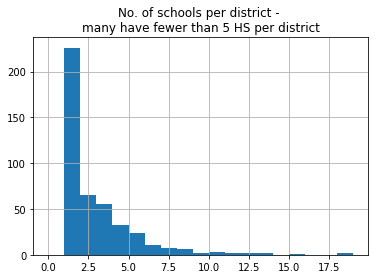

In [38]:
df_school_info_CA_schools.groupby('District').count()['School'].hist(bins=range(20))
plt.title('No. of schools per district - \nmany have fewer than 5 HS per district');

In [40]:
# Loop through each school in CA to get info

df_state = pd.DataFrame()

# Go district by district to avoid potential schools with similar names
for index_district, district in enumerate(df_school_info_CA_schools['District'].unique()):
    if index_district < 1000:
        #print(str(index_district), 'District queried: ', district)
        df_school_info_district = df_school_info_CA_schools.copy()[df_school_info_CA_schools['District']==district]
        for index, school in enumerate(df_school_info_district['School']):
            # Limit to high schools
            if index < 2000:
                try:
                    df = get_base_gs_school_info(school)
                    # Print to monitor, but limit the output
                    if index_district % 5 == 0:
                        print('District index: ', str(index_district), 'School index: ', str(index), school, df.shape, '\n -----')
                    if len(df_state.columns) < 1:
                        df_state = df.copy()
                        df_state.columns = [school]
                        index2get = df.index
                    else:
                        df_state[school] = df.copy().loc[index2get, :]
                        #df_state[school] = df
                except:
                    df_state[school] = None

            else:
                break
                
    else:
        break

# Transpose
df_state_tp = df_state.T

District index:  0 School index:  0 Envision Academy for Arts & Technology (23, 1) 
 -----


/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


District index:  5 School index:  0 Emery Secondary (23, 1) 
 -----
District index:  10 School index:  0 James Logan High (23, 1) 
 -----
District index:  15 School index:  0 Dublin High (23, 1) 
 -----
District index:  20 School index:  0 Inspire School of Arts and Sciences (23, 1) 
 -----
District index:  20 School index:  1 Chico High (23, 1) 
 -----
District index:  20 School index:  2 Pleasant Valley High (23, 1) 
 -----
District index:  25 School index:  0 Bret Harte Union High (23, 1) 
 -----
District index:  30 School index:  0 Williams Junior/Senior High (23, 1) 
 -----
District index:  35 School index:  0 Heritage High (23, 1) 
 -----
District index:  35 School index:  1 Freedom High (23, 1) 
 -----
District index:  35 School index:  2 Liberty High (23, 1) 
 -----
District index:  40 School index:  0 Dougherty Valley High (23, 1) 
 -----
District index:  40 School index:  1 California High (23, 1) 
 -----
District index:  40 School index:  2 Monte Vista High (23, 1) 
 -----
D

District index:  290 School index:  1 Adelanto High (22, 1) 
 -----
District index:  290 School index:  3 Options for Youth-Victorville Charter (23, 1) 
 -----
District index:  290 School index:  4 Silverado High (23, 1) 
 -----
District index:  290 School index:  5 Victor Valley High (23, 1) 
 -----
District index:  290 School index:  6 Cobalt Institute of Math and Science Academy (23, 1) 
 -----
District index:  295 School index:  0 Summit Leadership Academy-High Desert (23, 1) 
 -----
District index:  295 School index:  1 Mirus Secondary (22, 1) 
 -----
District index:  295 School index:  3 Oak Hills High (23, 1) 
 -----
District index:  295 School index:  4 Hesperia High (23, 1) 
 -----
District index:  295 School index:  5 Sultana High (23, 1) 
 -----
District index:  300 School index:  0 San Diego Workforce Innovation High (20, 1) 
 -----
District index:  300 School index:  1 Borrego Springs High (23, 1) 
 -----
District index:  305 School index:  0 River Valley Charter (23, 1) 


In [42]:
# Count number of rows with less than 5 null values out of the 23 targeted to scrape

print(str((df_state_tp.isnull().sum(axis=1) < 5).sum())
      +  ' GS schools info obtained out of ' 
      + str(df_state_tp.shape[0]) 
      + ' schools queried' )


no_of_schools_wlink = df_state_tp['overviewLink'].notnull().sum()
print('no. of schools with GS link: ', str(no_of_schools_wlink))

no_of_schools_wlink = df_state_tp['overviewLink'].notnull().sum()

1151 GS schools info obtained out of 1253 schools queried
no. of schools with GS link:  1165


In [43]:
df_state_tp['overviewLink'].notnull().sum()

1165

In [44]:
df_state_tp.loc[df_state_tp.isnull().sum(axis=1) > 5, :]

tags,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,phone,fax,website,ncesId,lat,lon,overviewLink,ratingsLink,reviewsLink,schoolStatsLink
Silver Oak High Public Montessori Charter,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
MetWest High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
McClymonds High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Paradise eLearning Academy,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Maxwell Sr High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Clayton Valley Charter High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
De Anza High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
El Cerrito High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Big Picture Educational Academy,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
McLane High,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [47]:
# Save csv so it's not necessary to reprocess
#df_state_tp.to_csv('repo/df_state_tp_WITH_URL_191006.csv')

#### Get high-level ratings using school profile page

For college readiness, test scores, advanced courses,
equity overview, race ethnicity, low income, disabilities

**Note: (API not required here)**

In [769]:
# Test query
# school = df_school_info_sd_schools_su['School'].iloc[5]
# print(school.replace(' ','-'))
# url = df_district_tp.loc[school, 'overviewLink']
# socket_read = urllib.request.urlopen(url).read()
# soup = BeautifulSoup(socket_read, 'html.parser')
# url_test = 'https://www.greatschools.org/california/chula-vista/6279-Bonita-Vista-Senior-High-School/?utm_source=GSAPI&utm_medium=referral'

In [34]:
def get_high_level_ratings(url_school):

    try:
        socket_read = urllib.request.urlopen(url_school).read()   # uncomment when there's internet
        soup = BeautifulSoup(socket_read, 'html.parser')
    
    except:
        soup = None

    rating_categories = (['College_readiness', 'Test_scores', 'Advanced_courses',
                         'Equity_overview', 'Race_ethnicity', 'Low-income_students',
                         'Students_with_Disabilities'])
        
    rating_list = list()
    for rating_cat in rating_categories:
        #print(rating_cat)
        try:
            tags = soup.find_all(href=re.compile(rating_cat))
            this_cat_rating_list = []
            for tag in tags:
                for index, child in enumerate(tag.contents):
                    if "rating" in str(child):
                        this_child = str(child)
                        rating = (int(this_child.split('--')[1].split()[0]))
                        this_cat_rating_list.append(rating)
                    else:
                        #print("no rating")
                        this_cat_rating_list.append('no_rating')

                # If there's no rating in any tag for that category, record it as None
                if False not in [i=='no_rating' for i in this_cat_rating_list]:
                    rating = None

        except:
            rating = None
            
        rating_list.append(rating)
        
    return rating_list

##### Testing with Sweetwater Union

In [ ]:
# Commented out if needed to start next loop at a certain index

# col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
# # Initiate columns
# for rating in col_hl_ratings:
#     df_district_tp.loc[:, rating] = None



In [92]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# Use enumerate option to start at a certain index and not start over
for i, url in enumerate(df_district_tp['overviewLink'], 9):
    print(i)
    #try:
#     index_school = df_district_tp.index[i]
#     df_district_tp.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)
#     print(str(i+1) + ' of ' + str(len(df_district_tp)) + ': ' + index_school)    # To monitor output
    #except:
    #    continue


9
10
11
12
13
14
15
16
17
18
19
20


In [114]:
df_district_tp['overviewLink'].iloc[9:]

Mar Vista Senior High     https://www.greatschools.org/california/imperi...
Sweetwater High           https://www.greatschools.org/california/nation...
Montgomery Senior High    https://www.greatschools.org/california/san-di...
Name: overviewLink, dtype: object

In [117]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# Careful with this - 

start_val = 9
for i, url in enumerate(df_district_tp['overviewLink'].iloc[start_val:]):
    index_school = df_district_tp.index[i+start_val]
    print(i, index_school, url)
#     try:
#         index_school = df_district_tp.index[i]
#         df_district_tp.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)
#         no_of_values = df_district_tp.loc[index_school, col_hl_ratings].notnull().sum()
#         print(str(i+1) + ' of ' + str(len(df_district_tp)) + ': ' + index_school + ' - ' + str(no_of_values))    # To monitor output
#     except:
#         continue



0 Mar Vista Senior High https://www.greatschools.org/california/imperial-beach/6289-Mar-Vista-Senior-High-School/?utm_source=GSAPI&utm_medium=referral
1 Sweetwater High https://www.greatschools.org/california/national-city/6297-Sweetwater-High-School/?utm_source=GSAPI&utm_medium=referral
2 Montgomery Senior High https://www.greatschools.org/california/san-diego/6291-Montgomery-Senior-High-School/?utm_source=GSAPI&utm_medium=referral


#####  Testing with LA Unified

In [1291]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
# # Initiate columns
# for rating in col_hl_ratings:
#     df_district_tp_LA.loc[:, rating] = None
    
# for i, url in enumerate(df_district_tp_LA['overviewLink']):
#     index_school = df_district_tp_LA.index[i]
#     print(str(i+1) + ' of ' + str(len(df_district_tp_LA)) + ': ' + index_school)    # To monitor output
#     df_district_tp_LA.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)

1 of 160: High Tech LA
2 of 160: Wallis Annenberg High
3 of 160: Central City Value
4 of 160: ICEF View Park Preparatory Accelerated High
5 of 160: CATCH Prep Charter High, Inc.
6 of 160: Oscar De La Hoya Animo Charter High
7 of 160: Animo South Los Angeles Charter
8 of 160: Middle College High
9 of 160: Dr. Richard A. Vladovic Harbor Teacher Preparation Academy
10 of 160: Camino Nuevo Charter High
11 of 160: Animo Venice Charter High
12 of 160: Animo Pat Brown
13 of 160: Northridge Academy High
14 of 160: Port of Los Angeles High
15 of 160: CHAMPS - Charter HS of Arts-Multimedia & Performing
16 of 160: Alliance Judy Ivie Burton Technology Academy High
17 of 160: Alliance Collins Family College-Ready High
18 of 160: Santee Education Complex
19 of 160: South East High
20 of 160: Maywood Academy High
21 of 160: New Village Girls Academy
22 of 160: Alliance Patti And Peter Neuwirth Leadership Academy
23 of 160: Alliance Dr. Olga Mohan High
24 of 160: Animo Ralph Bunche Charter High
25 of 

##### Full CA high school data

In [114]:
# Commented out if needed to start next loop at a certain index

col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
# # Initiate columns
# for rating in col_hl_ratings:
#     df_state_tp.loc[:, rating] = None


In [119]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# For debugging - start at a certain row and not have to start over
# Don't use enumerate option since the url doesn't track with the option

start_val = 350
for i, url in enumerate(df_state_tp['overviewLink'].iloc[start_val:]):
    index_school = df_state_tp.index[i+start_val]
    try:
        if url is not None:
            df_state_tp.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)
            no_of_values = df_state_tp.loc[index_school, col_hl_ratings].notnull().sum()
        else:
            df_state_tp.loc[index_school, col_hl_ratings] = None
    except:
        df_state_tp.loc[index_school, col_hl_ratings] = None
    if i % 10 == 0:
        print(str(i+1+start_val) + ' of ' + str(len(df_state_tp)) + ': ' + index_school + ' - ' + str(no_of_values))    # To monitor output


1 of 1253: Contreras Learning Center-Academic Leadership Community - 4
11 of 1253: Alliance Tennenbaum Family Technology High - 4
21 of 1253: Valley Academy of Arts and Sciences - 4
31 of 1253: Synergy Quantum Academy - 4
41 of 1253: Augustus F. Hawkins High B Community Health Advocates - 4
51 of 1253: Alliance Alice M. Baxter College-Ready High - 3
61 of 1253: Collegiate Charter High School of Los Angeles - 3
71 of 1253: Matrix for Success Academy - 0
81 of 1253: Grover Cleveland Charter High - 4
91 of 1253: Ulysses S. Grant Senior High - 4
101 of 1253: James Monroe High - 4
111 of 1253: University High School Charter - 4
121 of 1253: Monrovia High - 4
131 of 1253: Odyssey STEM Academy - 0
141 of 1253: Fremont Academy of Engineering and Design - 4
151 of 1253: Pioneer High - 4
161 of 1253: Opportunities for Learning - Santa Clarita - 4
171 of 1253: John A. Rowland High - 4
181 of 1253: Mira Costa High - 4
191 of 1253: Madera South High - 4
201 of 1253: San Rafael High - 4
211 of 1253:

In [98]:
# Something to fix if there's time
# df_state_tp.iloc[360:365, :]

tags,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,ratingsLink,reviewsLink,schoolStatsLink,college_readiness,test_scores,advanced_courses,equity_overview,race_ethnicity,low_income,disabilities
Alliance Tennenbaum Family Technology High,25748,Alliance Tennenbaum Family Technology High,charter,9-12,408,6,4,Los Angeles,CA,286,...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,10,10,None,None,None,10,None
"Math, Science, & Technology Magnet Academy at Roosevelt High",2496,Windsor Hills Math Science,public,K-5,530,4,4,Los Angeles,CA,286,...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,2,4,None,4,None,4,None
Esteban Torres East LA Performing Arts Magnet,None,None,None,None,None,None,None,None,None,None,...,None,None,None,8,9,None,10,None,9,None
Humanitas Academy of Art and Technology at Esteban E. Torres High No. 4,25437,Humanitas Academy Of Art And Technology At Est...,public,9-12,493,4,NaN,Los Angeles,CA,286,...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,None,None,None,None,None,None,None
Social Justice Leadership Academy at Esteban E. Torres High No. 5,25474,Social Justice Leadership Academy At Esteban E...,public,9-12,406,3,NaN,Los Angeles,CA,286,...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,https://www.greatschools.org/california/los-an...,4,5,None,4,None,4,None


In [130]:
# Count number of rows with some null values out of the 30 targeted to scrape
# print(str((df_state_tp.isnull().sum(axis=1) < 5).sum())
#       +  ' GS schools info obtained out of ' 
#       + str(df_state_tp.shape[0]) 
#       + ' schools queried' )

no_of_schools_w_4HLratings = (df_state_tp.loc[:, col_hl_ratings].notnull().sum(axis=1) >=3).sum()
print(str(no_of_schools_w_4HLratings) + ' GS schools with at least 3 of the 4 high-level ratings out of ' + str(no_of_schools_wlink) + ' with a link')

1028 GS schools with at least 3 of the 4 high-level ratings out of 1165 with a link


In [125]:
# CSV to save I don't have to start over
#df_state_tp.to_csv('repo/df_state_tp_WITH_URL-HLdone997schoolsWinfo_191006.csv')

In [126]:
#df_state_tp.tail()

tags,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,ratingsLink,reviewsLink,schoolStatsLink,college_readiness,test_scores,advanced_courses,equity_overview,race_ethnicity,low_income,disabilities
Woodland Senior High,7829,Woodland Senior High School,public,9-12,1318,5,3,Woodland,CA,1041,...,https://www.greatschools.org/california/woodla...,https://www.greatschools.org/california/woodla...,https://www.greatschools.org/california/woodla...,5,4,None,3,None,3,None
Lindhurst High,7771,Lindhurst High School,public,9-12,1122,3,4,Olivehurst,CA,1032,...,https://www.greatschools.org/california/oliveh...,https://www.greatschools.org/california/oliveh...,https://www.greatschools.org/california/oliveh...,3,3,None,2,None,2,None
Marysville Charter Academy for the Arts,11901,Marysville Charter Academy For The Arts,charter,7-12,376,8,5,Marysville,CA,1032,...,https://www.greatschools.org/california/marysv...,https://www.greatschools.org/california/marysv...,https://www.greatschools.org/california/marysv...,9,8,None,8,None,8,None
Marysville High,7773,Marysville High School,public,9-12,893,5,4,Marysville,CA,1032,...,https://www.greatschools.org/california/marysv...,https://www.greatschools.org/california/marysv...,https://www.greatschools.org/california/marysv...,8,3,None,2,None,2,None
Wheatland Union High,7785,Wheatland Union High School,public,9-12,707,5,3,Wheatland,CA,1035,...,https://www.greatschools.org/california/wheatl...,https://www.greatschools.org/california/wheatl...,https://www.greatschools.org/california/wheatl...,7,5,None,3,None,3,None


In [31]:
# Loading CSV back into memory
df_state_tp = pd.read_csv('repo/df_state_tp_WITH_URL-HLdone997schoolsWinfo_191006.csv', index_col=0)

In [32]:
df_state_tp.head()

,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,ratingsLink,reviewsLink,schoolStatsLink,college_readiness,test_scores,advanced_courses,equity_overview,race_ethnicity,low_income,disabilities
Envision Academy for Arts & Technology,16870.0,Envision Academy For Arts & Technology,charter,9-12,407.0,4.0,3.0,Oakland,CA,1069.0,...,https://www.greatschools.org/california/oaklan...,https://www.greatschools.org/california/oaklan...,https://www.greatschools.org/california/oaklan...,1.0,4.0,NaN,5.0,NaN,4.0,NaN
Alameda High,1.0,Alameda High School,public,9-12,1853.0,9.0,4.0,Alameda,CA,1.0,...,https://www.greatschools.org/california/alamed...,https://www.greatschools.org/california/alamed...,https://www.greatschools.org/california/alamed...,10.0,9.0,NaN,7.0,NaN,8.0,NaN
Alternatives in Action,11903.0,Alternatives in Action,charter,9-12,165.0,NaN,4.0,Oakland,CA,1.0,...,https://www.greatschools.org/california/oaklan...,https://www.greatschools.org/california/oaklan...,https://www.greatschools.org/california/oaklan...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albany High,19.0,Albany High School,public,9-12,1210.0,9.0,4.0,Albany,CA,2.0,...,https://www.greatschools.org/california/albany...,https://www.greatschools.org/california/albany...,https://www.greatschools.org/california/albany...,9.0,9.0,NaN,9.0,NaN,8.0,NaN
Berkeley High,25.0,Berkeley High School,public,9-12,3205.0,8.0,4.0,Berkeley,CA,3.0,...,https://www.greatschools.org/california/berkel...,https://www.greatschools.org/california/berkel...,https://www.greatschools.org/california/berkel...,9.0,9.0,NaN,3.0,NaN,5.0,NaN


#### Obtain GS details on teacher and low income data

In [35]:
def get_school_page_doc(url_school):
    try:
        socket_read = urllib.request.urlopen(url_school).read()   # uncomment when there's internet
        soup = BeautifulSoup(socket_read, 'html.parser')
        school_page_doc = soup.get_text()
    except:
        school_page_doc = None
    return school_page_doc

In [36]:
def get_relevant_texts_teachers(my_text):
    try:
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 300
        for this_match in range(len(my_str_loc)):
            #if "\"label\"" in school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]:
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
    except:
        relevant_text = None
    return relevant_text

In [37]:
# This was arbitrarily chosen because it's the middle category
# but I tried other things and this seemed to work well to get the right section
# teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')

In [38]:
def get_ratios_for_staff(text):
    try:
        text2get = text
        # Added this next line
        teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
        text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
        text2get_loc_end = text2get_loc_start + len(text2get)
        ratio_loc = teacher_text.replace('\n', '').find(':', text2get_loc_end)
        student_to_one_staff = int(teacher_text.replace('\n', '')[text2get_loc_end:ratio_loc].strip())
    except:
        student_to_one_staff = None
    return student_to_one_staff


In [39]:
def get_percentages_for_staff(text):
    try:
        text2get = text
        # Added this next line
        teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
        text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
        text2get_loc_end = text2get_loc_start + len(text2get)
        character_loc = teacher_text.replace('\n', '').find('%', text2get_loc_end)
        percent_staff = int(teacher_text.replace('\n', '')[text2get_loc_end:character_loc].strip())
    except:
        percent_staff = None
    return percent_staff

In [40]:
def get_salary(text):
    try:
        text2get = text
        # Added this next line
        teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
        text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
        text2get_loc_end = text2get_loc_start + len(text2get)
        character_loc = teacher_text.replace('\n', '').find('$', text2get_loc_end)
        end_of_salary_loc = teacher_text.replace('\n', '').find(' ', character_loc)
        salary = int(teacher_text.replace('\n', '')[character_loc+1:end_of_salary_loc].replace(',',''))
    except:
        salary = None
    return salary

In [41]:
# Testing
# Add this to individual school info and then dataframe
# (get_ratios_for_staff('Students per teacher'),
#  get_ratios_for_staff('Students per counselor'),
#  get_percentages_for_staff('Percentage of teachers with 3 or more years experience'),
#  get_percentages_for_staff('% of full time teachers who are certified '),
#  get_salary('Average teacher salary'))

In [42]:
def get_pct_lowincome_students(school_page_doc):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        #min_max_to_look = 250  # use for other things
        min_max_to_look = 100
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if '"breakdown":"Low-income","breakdown_in_english":"Economically disadvantaged"' in relevant_text:
                #print('   =============   ' + str(counter) + '   === (no. of low income?) ==========   ')
                #print(relevant_text)
                counter += 1
                break
    except:
        relevant_text = None
        
    try:
        str2find = '"percentage":'
        str2find_loc_start = relevant_text.find(str2find)
        str2find_loc_end = str2find_loc_start + len(str2find)
        pct_low_income_loc_end = relevant_text.find(',', str2find_loc_end)
        pct_low_income = int(relevant_text[str2find_loc_end:pct_low_income_loc_end].strip('"'))
    except:
        pct_low_income = None
    
    return pct_low_income

In [43]:
def get_lowincome_test_scores_overview(school_page_doc):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 400
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if 'label' in relevant_text and counter==0:
                #print('   =============   ' + str(counter) + '   === (label) ==========   ')
                #print(relevant_text)
                counter += 1
                break
    except:
        relevant_text = None
        
    try:  
        str2find = '"All students","label":'
        text_loc_start = relevant_text.find(str2find)
        text_loc_end = text_loc_start + len(str2find)
        score_start = relevant_text.find('"score":', text_loc_end)
        score_end = relevant_text.find(',', score_start)
        score_AS = int(relevant_text[score_start:score_end].split(':')[1])
    except:
        score_AS = None

    try:
        str2find = '"Economically disadvantaged","label":'
        text_loc_start = relevant_text.find(str2find)
        text_loc_end = text_loc_start + len(str2find)
        score_start = relevant_text.find('"score":', text_loc_end)
        score_end = relevant_text.find(',', score_start)
        score_LI = int(relevant_text[score_start:score_end].split(':')[1])
    except:
        score_LI = None

    try:
        str2find = '"Not economically disadvantaged","label":'
        text_loc_start = relevant_text.find(str2find)
        text_loc_end = text_loc_start + len(str2find)
        score_start = relevant_text.find('"score":', text_loc_end)
        score_end = relevant_text.find(',', score_start)
        score_notLI = int(relevant_text[score_start:score_end].split(':')[1])
    except:
        score_notLI = None

    return (score_AS, score_LI, score_notLI)

In [44]:
def get_lowincome_test_scores_for_subject(school_page_doc, subject):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 350
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if 'label' in relevant_text and subject in relevant_text:
                #print('   =============   ' + str(counter) + '   === (label) ==========   ')
                #print(relevant_text)
                counter += 1
                break
    except:
        relevant_text = None
    
    # Get all students info
    try:
        str2find = '"All students","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_AS = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_AS = None

    try:
        str2find_no_students = '"number_students_tested":'
        no_students_loc_start = relevant_text.find(str2find_no_students, low_inc_score_loc_end)
        no_students_loc_end = no_students_loc_start + len(str2find_no_students)
        #score_start = no_students_loc_end + 1
        score_end = relevant_text.find(',', no_students_loc_end)
        no_students_tested_AS = int(relevant_text[no_students_loc_end:score_end])
    except:
        no_students_tested_AS = None
    
    # Get low income info
    try:
        str2find = '"Economically disadvantaged","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_LI = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_LI = None
        
    try:    
        str2find_no_students = '"number_students_tested":'
        no_students_loc_start = relevant_text.find(str2find_no_students, low_inc_score_loc_end)
        no_students_loc_end = no_students_loc_start + len(str2find_no_students)
        #score_start = no_students_loc_end + 1
        score_end = relevant_text.find(',', no_students_loc_end)
        no_students_tested_LI = int(relevant_text[no_students_loc_end:score_end])
    except:
        no_students_tested_LI = None
    
    return (score_AS, no_students_tested_AS, score_LI, no_students_tested_LI)

In [45]:
def get_lowincome_gradrates_college_eligibility(school_page_doc, grad_category):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 300
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if 'label' in relevant_text and grad_category in relevant_text:
                #print('   =============   ' + str(counter) + '   === (label) ==========   ')
                #print(relevant_text)
                counter += 1
                break
                
    except:
        relevant_text = None

    try:
        str2find = '"All students","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_AS = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_AS = None

    try:
        str2find = '"Low-income","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_LI = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_LI = None

    return (score_AS, score_LI)

##### Testing with Sweetwater Union

In [160]:
# Initiate teacher rating columns
col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
for rating in col_teacher_ratings:
    df_district_tp.loc[:, rating] = None

# Initiate low income data columns
col_lowincome_ratings = (['test_score_rating_allStudents',
                          'test_score_rating_LIstudents',
                          'test_score_rating_notLIstudents',
                          'test_scores_english_allStudents',
                          'test_scores_english_allStudents_n_students',
                          'test_scores_english_LIstudents',
                          'test_scores_english_LIstudents_n_students',
                          'test_scores_math_allStudents',
                          'test_scores_math_allStudents_n_students',
                          'test_scores_math_LIstudents',
                          'test_scores_math_LIstudents_n_students',
                          'graduation_rates_UCCSU_eligibility_allStudents',
                          'graduation_rates_UCCSU_eligibility_LIstudents',
                          'graduation_rates_gradRates_eligibility_allStudents',
                          'graduation_rates_gradRates_eligibility_LIstudents',
                          'pct_LI_students'])
for rating in col_lowincome_ratings:
    df_district_tp.loc[:, rating] = None

    

start_val = 3
end_val = 5
for i, url in enumerate(df_district_tp['overviewLink'].iloc[start_val:end_val]):
    index_school = df_district_tp.index[i+start_val]
     
# for i, url in enumerate(df_district_tp['overviewLink']):
#     index_school = df_district_tp.index[i]
    print(str(i+1+start_val) + ' of ' + str(len(df_district_tp)) + ': ' + index_school)    # To monitor output
    school_page_doc = get_school_page_doc(url)
    
    # Detailed teacher info
    df_district_tp.loc[index_school, 'students_per_teacher'] = get_ratios_for_staff('Students per teacher')
    df_district_tp.loc[index_school, 'students_per_counselor'] = get_ratios_for_staff('Students per counselor')
    df_district_tp.loc[index_school, 'pct_teachers_3years_or_more'] = get_percentages_for_staff('Percentage of teachers with 3 or more years experience')
    df_district_tp.loc[index_school, 'pct_teachers_who_r_certified'] = get_percentages_for_staff('% of full time teachers who are certified')
    df_district_tp.loc[index_school, 'avg_teacher_salary'] = get_salary('Average teacher salary')
    
    # Detailed low income info
    df_district_tp.loc[index_school, col_lowincome_ratings[0:3]] = get_lowincome_test_scores_overview(school_page_doc)
    df_district_tp.loc[index_school, col_lowincome_ratings[3:7]] = get_lowincome_test_scores_for_subject(school_page_doc, 'English Language Arts')
    df_district_tp.loc[index_school, col_lowincome_ratings[7:11]] = get_lowincome_test_scores_for_subject(school_page_doc, 'Math')
    df_district_tp.loc[index_school, col_lowincome_ratings[11:13]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'UC/CSU eligibility')
    df_district_tp.loc[index_school, col_lowincome_ratings[13:15]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'Graduation rates')
    df_district_tp.loc[index_school, col_lowincome_ratings[15]] = get_pct_lowincome_students(school_page_doc)

print('done getting schools in this set')

4 of 12: Castle Park Senior High
5 of 12: Eastlake High
done getting schools in this set


##### Testing with LA Unified

In [227]:
#col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
# # Initiate columns
# for rating in col_teacher_ratings:
#     df_district_tp_LA.loc[:, rating] = None
    
# for i, url in enumerate(df_district_tp_LA['overviewLink']):
#     index_school = df_district_tp_LA.index[i]
#     print(str(i+1) + ' of ' + str(len(df_district_tp_LA)) + ': ' + index_school)    # To monitor output
#     school_page_doc = get_school_page_doc(url)
#     #teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
#     df_district_tp_LA.loc[index_school, 'students_per_teacher'] = get_ratios_for_staff('Students per teacher')
#     # print(get_ratios_for_staff('Students per teacher'))
#     df_district_tp_LA.loc[index_school, 'students_per_counselor'] = get_ratios_for_staff('Students per counselor')
#     df_district_tp_LA.loc[index_school, 'pct_teachers_3years_or_more'] = get_percentages_for_staff('Percentage of teachers with 3 or more years experience')
#     df_district_tp_LA.loc[index_school, 'pct_teachers_who_r_certified'] = get_percentages_for_staff('% of full time teachers who are certified')
#     df_district_tp_LA.loc[index_school, 'avg_teacher_salary'] = get_salary('Average teacher salary')

##### Full CA high school data

In [288]:
col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']

col_lowincome_ratings = (['test_score_rating_allStudents',
                          'test_score_rating_LIstudents',
                          'test_score_rating_notLIstudents',
                          'test_scores_english_allStudents',
                          'test_scores_english_allStudents_n_students',
                          'test_scores_english_LIstudents',
                          'test_scores_english_LIstudents_n_students',
                          'test_scores_math_allStudents',
                          'test_scores_math_allStudents_n_students',
                          'test_scores_math_LIstudents',
                          'test_scores_math_LIstudents_n_students',
                          'graduation_rates_UCCSU_eligibility_allStudents',
                          'graduation_rates_UCCSU_eligibility_LIstudents',
                          'graduation_rates_gradRates_eligibility_allStudents',
                          'graduation_rates_gradRates_eligibility_LIstudents',
                          'pct_LI_students'])

In [60]:
# Initiate teacher rating columns - comment out to start mid-loop
# col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
# for rating in col_teacher_ratings:
#     df_state_tp.loc[:, rating] = None

# # Initiate low income data columns
# col_lowincome_ratings = (['test_score_rating_allStudents',
#                           'test_score_rating_LIstudents',
#                           'test_score_rating_notLIstudents',
#                           'test_scores_english_allStudents',
#                           'test_scores_english_allStudents_n_students',
#                           'test_scores_english_LIstudents',
#                           'test_scores_english_LIstudents_n_students',
#                           'test_scores_math_allStudents',
#                           'test_scores_math_allStudents_n_students',
#                           'test_scores_math_LIstudents',
#                           'test_scores_math_LIstudents_n_students',
#                           'graduation_rates_UCCSU_eligibility_allStudents',
#                           'graduation_rates_UCCSU_eligibility_LIstudents',
#                           'graduation_rates_gradRates_eligibility_allStudents',
#                           'graduation_rates_gradRates_eligibility_LIstudents',
#                           'pct_LI_students'])
# for rating in col_lowincome_ratings:
#     df_state_tp.loc[:, rating] = None

# Set start and end to avoid hangups
start_val = 799
end_val = len(df_state_tp)
#for i, url in enumerate(df_state_tp['overviewLink'].iloc[start_val:end_val]):
    index_school = df_state_tp.index[i+start_val]
    #print(str(i+1+start_val) + ' of ' + str(len(df_state_tp)) + ': ' + index_school)    # To monitor output
    # Monitor output but don't print everything
    if i % 10==0:
        print(str(i+1+start_val) + ' of ' + str(len(df_state_tp)) + ': ' + index_school)    # To monitor output
    school_page_doc = get_school_page_doc(url)
    
    # Detailed teacher info
    df_state_tp.loc[index_school, 'students_per_teacher'] = get_ratios_for_staff('Students per teacher')
    df_state_tp.loc[index_school, 'students_per_counselor'] = get_ratios_for_staff('Students per counselor')
    df_state_tp.loc[index_school, 'pct_teachers_3years_or_more'] = get_percentages_for_staff('Percentage of teachers with 3 or more years experience')
    df_state_tp.loc[index_school, 'pct_teachers_who_r_certified'] = get_percentages_for_staff('% of full time teachers who are certified')
    df_state_tp.loc[index_school, 'avg_teacher_salary'] = get_salary('Average teacher salary')
    
    # Detailed low income info
    df_state_tp.loc[index_school, col_lowincome_ratings[0:3]] = get_lowincome_test_scores_overview(school_page_doc)
    df_state_tp.loc[index_school, col_lowincome_ratings[3:7]] = get_lowincome_test_scores_for_subject(school_page_doc, 'English Language Arts')
    df_state_tp.loc[index_school, col_lowincome_ratings[7:11]] = get_lowincome_test_scores_for_subject(school_page_doc, 'Math')
    df_state_tp.loc[index_school, col_lowincome_ratings[11:13]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'UC/CSU eligibility')
    df_state_tp.loc[index_school, col_lowincome_ratings[13:15]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'Graduation rates')
    df_state_tp.loc[index_school, col_lowincome_ratings[15]] = get_pct_lowincome_students(school_page_doc)

print('done getting schools in this set')

800 of 1253: Natomas High
810 of 1253: Big Bear High
820 of 1253: Ruben S. Ayala High
830 of 1253: Fontana High
840 of 1253: Rialto High
850 of 1253: San Gorgonio High
860 of 1253: Baker High
870 of 1253: Elite Academic Academy - Adult Work Force Investment
880 of 1253: Classical Academy High
890 of 1253: Steele Canyon High
900 of 1253: Westview High
910 of 1253: San Diego Science and Technology
920 of 1253: Charter School of San Diego
930 of 1253: Canyon Crest Academy
940 of 1253: MAAC Community Charter
950 of 1253: Vista High
960 of 1253: High Tech High Chula Vista
970 of 1253: Burton (Phillip and Sala) Academic High
980 of 1253: O'Connell (John) High
990 of 1253: be.tech
1000 of 1253: Millennium Charter
1010 of 1253: Morro Bay High
1020 of 1253: Terra Nova High
1030 of 1253: Summit Preparatory Charter High
1040 of 1253: Lompoc High
1050 of 1253: Summit Public School: Tahoma
1060 of 1253: ACE Charter High
1070 of 1253: James Lick High
1080 of 1253: Dr. TJ Owens Gilroy Early College A

In [61]:
# No. of schools with at least 5 of the 21 detailed ratings
no_of_schools_wdetailed_ratings = (df_state_tp.loc[:, col_teacher_ratings + col_lowincome_ratings].isnull().sum(axis=1) < 5).sum()
print('', str(no_of_schools_wdetailed_ratings))

 1001


In [62]:
# CSV to save I don't have to start over
# df_state_tp.to_csv('repo/df_state_tp_WITH_URL-HLdone997schoolsWinfo_WdetailsALLschools_191007.csv')

In [63]:
df_state_tp.tail()

,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,test_scores_english_LIstudents_n_students,test_scores_math_allStudents,test_scores_math_allStudents_n_students,test_scores_math_LIstudents,test_scores_math_LIstudents_n_students,graduation_rates_UCCSU_eligibility_allStudents,graduation_rates_UCCSU_eligibility_LIstudents,graduation_rates_gradRates_eligibility_allStudents,graduation_rates_gradRates_eligibility_LIstudents,pct_LI_students
Woodland Senior High,7829.0,Woodland Senior High School,public,9-12,1318.0,5.0,3.0,Woodland,CA,1041.0,...,196,18,303,14,196,42,38,89,88,63
Lindhurst High,7771.0,Lindhurst High School,public,9-12,1122.0,3.0,4.0,Olivehurst,CA,1032.0,...,194,13,230,12,197,31,30,90,90,84
Marysville Charter Academy for the Arts,11901.0,Marysville Charter Academy For The Arts,charter,7-12,376.0,8.0,5.0,Marysville,CA,1032.0,...,119,40,60,40,119,67,72,92,96,44
Marysville High,7773.0,Marysville High School,public,9-12,893.0,5.0,4.0,Marysville,CA,1032.0,...,118,16,185,11,117,33,29,97,97,62
Wheatland Union High,7785.0,Wheatland Union High School,public,9-12,707.0,5.0,3.0,Wheatland,CA,1035.0,...,72,23,162,13,70,52,51,98,99,37


### Merge datasets

In [ ]:
#  Merge on this - TO DO LATER
# From school info: NCESDist	NCESSchool  :  622710 + 11365
# On GS info: ncesId:   62271011365

# And filter out unrated schools (gsRating = None)
# df_school_info.head().loc[:, 'NCESDist'] + df_school_info.head().loc[:, 'NCESSchool']

# df_state_tp.head().loc[:, 'ncesId']

In [74]:
# Merge on school and zip code due to same named schools

# Need zip code in GS data
df_temp = df_state_tp['address'].str.split(expand=True)
col_index4zip = len(df_temp.columns) - df_temp.isnull().sum(axis=1) - 1

zipcode_list = list()
for i, col in enumerate(col_index4zip):
    if col != -1:
        zipcode = df_temp.iloc[i, col]
    else:
        zipcode = df_temp.iloc[i, 8]
    try:
        zipcode_list.append(int(zipcode))
    except:
        zipcode_list.append(None)
        
df_state_tp['zip_code_GS'] = zipcode_list
df_state_tp['schoolname4merge'] = df_state_tp.index

In [83]:
df_state_tp.head().index

Index(['Envision Academy for Arts & Technology', 'Alameda High',
       'Alternatives in Action', 'Albany High', 'Berkeley High'],
      dtype='object')

In [84]:
df_state_tp['name'].head()

Envision Academy for Arts & Technology    Envision Academy For Arts & Technology
Alameda High                                                 Alameda High School
Alternatives in Action                                    Alternatives in Action
Albany High                                                   Albany High School
Berkeley High                                               Berkeley High School
Name: name, dtype: object

In [86]:
bool_name_dup = df_state_tp['name'].duplicated(keep=False)

In [87]:
df_state_tp.loc[bool_name_dup, :]

,gsId,name,type,gradeRange,enrollment,gsRating,parentRating,city,state,districtId,...,test_scores_math_allStudents_n_students,test_scores_math_LIstudents,test_scores_math_LIstudents_n_students,graduation_rates_UCCSU_eligibility_allStudents,graduation_rates_UCCSU_eligibility_LIstudents,graduation_rates_gradRates_eligibility_allStudents,graduation_rates_gradRates_eligibility_LIstudents,pct_LI_students,schoolname4merge,zip_code_GS
Silver Oak High Public Montessori Charter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,Silver Oak High Public Montessori Charter,NaN
MetWest High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,MetWest High,NaN
McClymonds High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,McClymonds High,NaN
Paradise eLearning Academy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,Paradise eLearning Academy,NaN
Maxwell Sr High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,Maxwell Sr High,NaN
Clayton Valley Charter High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,Clayton Valley Charter High,NaN
De Anza High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,De Anza High,NaN
El Cerrito High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,El Cerrito High,NaN
Big Picture Educational Academy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,Big Picture Educational Academy,NaN
McLane High,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,McLane High,NaN


In [91]:
# Merge great schools and school info on zip code
df_state_info_gs = pd.merge(df_school_info, df_state_tp, how='inner',
                            left_on=['School', 'zip_code'],
                            right_on=['schoolname4merge', 'zip_code_GS'])

# Inspection showed a handful of schools in df_school_info with duplicate values for some reason
df_state_info_gs = df_state_info_gs.drop_duplicates(subset=['School', 'Street'], keep='last')

In [92]:
# Merge great schools, school info and demographic info on zip code
df_state_info_gs_census = pd.merge(df_state_info_gs, df_census,
                                      how='inner', left_on='zip_code', right_index=True)

In [195]:
# Save but comment after doing so
# df_state_info_gs_census.to_csv('repo/df_state_info_gs_census_ALL.csv')

Read in to avoid re-downloading data if necessary

In [957]:
df_state_info_gs_census = pd.read_csv('df_state_info_gs_census_ALL.csv', index_col=0)

In [958]:
# Replace magnet and charter status with category encoding variables
df_state_info_gs_census['Magnet_cat_encoded'] = df_state_info_gs_census['Magnet'].replace({'No Data':None, 'N':0, 'Y':1})
df_state_info_gs_census['Charter_cat_encoded'] = df_state_info_gs_census['Charter'].replace({'No Data':None, 'N':0, 'Y':1})

In [959]:
print('Dimensions of dataframe after data merging:\n', df_state_info_gs_census.shape)

Dimensions of dataframe after data merging:
 (1152, 219)


## Modeling and feature identification


In [960]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Feature categories

In [961]:
# Census columns that start with '%'
col_census_pct = df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.startswith('%')]
# Broad categories in pct census columns
print(set([i.split('-')[0] for i in col_census_pct.tolist()]))

{'%; INDUSTRY ', '%; WORK_COMMUTE ', '%; OCCUPATION ', '%; WORKER_CLASS ', '%; HEALTH_INS_COVERAGE ', '%; %', '%; EMPLOY_STATUS ', '%; INCOME_BENEFITS '}


In [962]:
# Census income columns (starts with 'Est')
col_census_est = df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.startswith('Est')]
# Change so that all are numeric/float
for col in col_census_est:
    df_state_info_gs_census[col] = pd.to_numeric(df_state_info_gs_census[col].copy(), 'float')
col_census_est.tolist()

['Est.; INCOME_BENEFITS - Total households - Median household income ($)',
 'Est.; INCOME_BENEFITS - Total households - Mean household income ($)',
 'Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)',
 'Est.; INCOME_BENEFITS - w/ retirement income',
 'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
 'Est.; INCOME_BENEFITS - w/ cash public assistance income',
 'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
 'Est.; INCOME_BENEFITS - Families - Median family income ($)',
 'Est.; INCOME_BENEFITS - Families - Mean family income ($)',
 'Est.; INCOME_BENEFITS - Per capita income ($)',
 'Est.; INCOME_BENEFITS - Nonfamily households - Median nonfamily income ($)',
 'Est.; INCOME_BENEFITS - Nonfamily households - Mean nonfamily income ($)']

In [963]:
# School info columns
col_school_info_magnet_charter = ['Magnet_cat_encoded', 'Charter_cat_encoded']
col_school_info_magnet_charter

['Magnet_cat_encoded', 'Charter_cat_encoded']

In [964]:
# High level GS school rating columns
col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
col_gs_hl_ratings = ['gsRating'] + col_hl_ratings
# Change so that all are numeric/float
for col in col_gs_hl_ratings:
    df_state_info_gs_census[col] = pd.to_numeric(df_state_info_gs_census[col].copy(), 'float')
    
col_gs_hl_ratings

['gsRating',
 'college_readiness',
 'test_scores',
 'advanced_courses',
 'equity_overview',
 'race_ethnicity',
 'low_income',
 'disabilities']

In [965]:
col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
col_teacher_ratings

['students_per_teacher',
 'students_per_counselor',
 'pct_teachers_3years_or_more',
 'pct_teachers_who_r_certified',
 'avg_teacher_salary']

In [966]:
col_lowincome_ratings = (['test_score_rating_allStudents',
                          'test_score_rating_LIstudents',
                          'test_score_rating_notLIstudents',
                          'test_scores_english_allStudents',
                          'test_scores_english_allStudents_n_students',
                          'test_scores_english_LIstudents',
                          'test_scores_english_LIstudents_n_students',
                          'test_scores_math_allStudents',
                          'test_scores_math_allStudents_n_students',
                          'test_scores_math_LIstudents',
                          'test_scores_math_LIstudents_n_students',
                          'graduation_rates_UCCSU_eligibility_allStudents',
                          'graduation_rates_UCCSU_eligibility_LIstudents',
                          'graduation_rates_gradRates_eligibility_allStudents',
                          'graduation_rates_gradRates_eligibility_LIstudents',
                          'pct_LI_students'])

# Need to remove target from this list without altering original list
col_lowincome_ratings_notarget = col_lowincome_ratings[:]
col_lowincome_ratings_notarget.remove('graduation_rates_UCCSU_eligibility_LIstudents')

col_lowincome_ratings_notarget

['test_score_rating_allStudents',
 'test_score_rating_LIstudents',
 'test_score_rating_notLIstudents',
 'test_scores_english_allStudents',
 'test_scores_english_allStudents_n_students',
 'test_scores_english_LIstudents',
 'test_scores_english_LIstudents_n_students',
 'test_scores_math_allStudents',
 'test_scores_math_allStudents_n_students',
 'test_scores_math_LIstudents',
 'test_scores_math_LIstudents_n_students',
 'graduation_rates_UCCSU_eligibility_allStudents',
 'graduation_rates_gradRates_eligibility_allStudents',
 'graduation_rates_gradRates_eligibility_LIstudents',
 'pct_LI_students']

In [967]:
all_features = (col_census_pct.tolist() + col_census_est.tolist() + 
                col_school_info_magnet_charter +
                col_gs_hl_ratings + col_teacher_ratings +
                col_lowincome_ratings_notarget)

In [968]:
all_features_filt = df_state_info_gs_census[all_features].dropna(thresh=0.67*len(df_state_info_gs_census), axis=1).columns.tolist()

In [971]:
print('No. of features where at least 2/3 of the schools have values for a feature: \n',
      len(all_features_filt))

No. of features where at least 2/3 of the schools have values for a feature: 
 137


### Distribution of target

In [972]:
target = df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents']
target_mean = target.mean()
target_sd = target.std()

print('mean: ', target_mean)
print('mean +/- 1SD: ', target_mean-target_sd, target_mean+target_sd)
print('mean + 2SD: ', target_mean-2*target_sd, target_mean+2*target_sd)

mean:  46.7021484375
mean +/- 1SD:  25.971879691038332 67.43241718396166
mean + 2SD:  5.241610944576664 88.16268593042334


In [973]:
df_state_info_gs_census['target_cat'] = pd.cut(target, [0, 25.97, 67.4, 88.1, 100],
                                               labels=['poor', 'average', 'good', 'exceptional'])

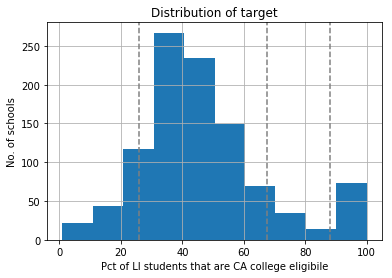

In [974]:
f, ax1 = plt.subplots()
ax1 = df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'].hist();
ax1.axvline(25.97, c='gray', linestyle='dashed')
ax1.axvline(67.4, c='gray', linestyle='dashed')
ax1.axvline(88.1, c='gray', linestyle='dashed')
ax1.set_title('Distribution of target')
ax1.set_xlabel('Pct of LI students that are CA college eligibile')
ax1.set_ylabel('No. of schools');

In [975]:
df_state_info_gs_census.groupby('target_cat').count()['School']

target_cat
poor           111
average        776
good            60
exceptional     77
Name: School, dtype: int64

In [976]:
df_state_info_gs_census['target_cat_encoded'] = df_state_info_gs_census['target_cat'].cat.codes
# Replace schools that have no value (-1; note: replace is giving weird response
k_bool = df_state_info_gs_census.copy()['target_cat_encoded'] < 0
df_state_info_gs_census.loc[k_bool, 'target_cat_encoded'] = None
df_state_info_gs_census[['target_cat', 'target_cat_encoded']].head(5)

,target_cat,target_cat_encoded
0,exceptional,3.0
1,average,1.0
2,exceptional,3.0
23,exceptional,3.0
3,average,1.0


In [977]:
print('No. of schools in each target group')
df_state_info_gs_census.groupby('target_cat_encoded').count()['School']

No. of schools in each target group


target_cat_encoded
0.0    111
1.0    776
2.0     60
3.0     77
Name: School, dtype: int64

### Logistic regression with 4 classes

In [1093]:
def return_logistic_model_stdscale(df, X_feature_list, y_feature, test_size_value):

    # Keep rows only if there are no null values for that feature and target
    k_rows2keep = df[X_feature_list + [y_feature]].notnull().sum(axis=1)==(len(X_feature_list) + 1)
    df_clean = df.copy().loc[k_rows2keep, X_feature_list + [y_feature]]
    
    if len(X_feature_list)==1:
        X = df_clean[X_feature_list[0]].copy().values.reshape(-1,1)
        y = df_clean[y_feature].copy().values.reshape(-1,1)
    else:
        X = df_clean[X_feature_list].copy().values
        y = df_clean[y_feature].copy().values

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_value, random_state=19)
    
    # Scale features based on training data
    std_scale = StandardScaler()
    X_train_scale = std_scale.fit_transform(X_train)
    
    # Apply scale to test
    X_test_scale = std_scale.transform(X_test)
    
    # Setup model to use lasso, multiclass (one vs. rest), saga can work with l1
    # increased max_iter
    reg_log = LogisticRegression(penalty='l1', multi_class='ovr',
                                 solver='saga', max_iter=10**4)
    reg_log.fit(X_train_scale, y_train)
    
    return reg_log, X_train_scale, X_test_scale, y_train, y_test

#### Teacher rating features

Using a limited set of features to inspect the model. I chose the teacher rating features since I'd assume that it has an impact on low income student success.

In [1094]:
X_feature_list = col_teacher_ratings
y = 'target_cat_encoded'
test_size = 0.4

(reg_logTf, X_train_scalelogTf, X_test_scalelogTf, y_train_logTf, y_test_logTf) = return_logistic_model_stdscale(df_state_info_gs_census, X_feature_list, y, test_size)

In [1095]:
print('No. of schools in model: ' + str((len(y_train_logTf) + len(y_test_logTf))) + 
      ' out of ' + str(len(df_state_info_gs_census)))

No. of schools in model: 967 out of 1152


In [1096]:
y_pred_logTf = reg_logTf.predict(X_test_scalelogTf)

In [1097]:
print(metrics.classification_report(y_test_logTf, y_pred_logTf))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        42
         1.0       0.79      0.99      0.88       307
         2.0       0.00      0.00      0.00        21
         3.0       0.25      0.06      0.10        17

   micro avg       0.79      0.79      0.79       387
   macro avg       0.26      0.26      0.24       387
weighted avg       0.64      0.79      0.70       387



/Users/lacar/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**F1 score is 0 for two of the four classes using the teacher features only. Look at all features.**

#### All features

In [1098]:
X_feature_list = all_features_filt
y = 'target_cat_encoded'
test_size = 0.4

(reg_logAllF, X_train_scalelogAllF, X_test_scalelogAllF, y_train_logAllF, y_test_logAllF) = return_logistic_model_stdscale(df_state_info_gs_census, X_feature_list, y, test_size)

In [1099]:
print('No. of schools in model: ' + str((len(y_train_logAllF) + len(y_test_logAllF))) + 
      ' out of ' + str(len(df_state_info_gs_census)))

No. of schools in model: 822 out of 1152


In [1100]:
y_pred_logAllF = reg_logAllF.predict(X_test_scalelogAllF)

In [1101]:
# precision denominator TP + FP
# recall(=sensitivity) denominator TP + FN
# F1 score: 2*(PR/P+R) ... if P or R are 0, then F is 0 (F close to 1 is good)
print(classification_report(y_test_logAllF, y_pred_logAllF))

              precision    recall  f1-score   support

         0.0       0.69      0.52      0.59        21
         1.0       0.92      0.97      0.95       280
         2.0       0.50      0.20      0.29        15
         3.0       1.00      0.77      0.87        13

   micro avg       0.90      0.90      0.90       329
   macro avg       0.78      0.62      0.67       329
weighted avg       0.89      0.90      0.89       329



**F1 score is low for most classes, even with all features**

Next step is to simplify the target by just doing two classes (binary classification).

### Logistic regression with two classes, all features

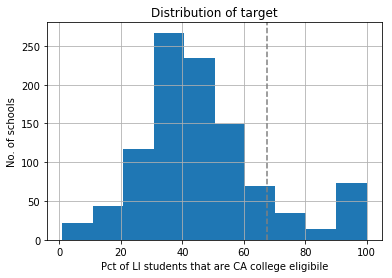

In [1102]:
f, ax1 = plt.subplots()
ax1 = df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'].hist();
ax1.axvline(67.4, c='gray', linestyle='dashed')
ax1.set_title('Distribution of target')
ax1.set_xlabel('Pct of LI students that are CA college eligibile')
ax1.set_ylabel('No. of schools');

In [1103]:
df_state_info_gs_census['target_cat_2classes'] = pd.cut(target, [0, 67.4, 100],
                                               labels=['poor-average', 'good-exceptional'])

In [1104]:
df_state_info_gs_census.groupby('target_cat_2classes').count()['School']

target_cat_2classes
poor-average        887
good-exceptional    137
Name: School, dtype: int64

In [1105]:
df_state_info_gs_census['target_cat_2classes_encoded'] = df_state_info_gs_census['target_cat_2classes'].cat.codes
df_state_info_gs_census['target_cat_2classes_encoded'].unique()


array([ 1,  0, -1])

In [1106]:
# Replace schools that have no value (-1; note: replace is giving weird response
k_bool = df_state_info_gs_census.copy()['target_cat_2classes_encoded'] < 0
df_state_info_gs_census.loc[k_bool, 'target_cat_2classes_encoded'] = None
df_state_info_gs_census.groupby('target_cat_2classes_encoded').count()['School']

target_cat_2classes_encoded
0.0    887
1.0    137
Name: School, dtype: int64

In [1133]:
X_feature_list = all_features_filt
y = 'target_cat_2classes_encoded'
test_size = 0.25

(reg_logAllF_2classes_stdscale, X_train_scalelogAllF_2classes_stdscale, X_test_scalelogAllF_2classes_stdscale, y_train_logAllF_2classes_stdscale, y_test_logAllF_2classes_stdscale) = return_logistic_model_stdscale(df_state_info_gs_census, X_feature_list, y, test_size)

In [1134]:
#all_features_filt[0:-4]

In [1135]:
y_pred_logAllF_2classes_stdscale = reg_logAllF_2classes_stdscale.predict(X_test_scalelogAllF_2classes_stdscale)

In [1136]:
print(metrics.classification_report(y_test_logAllF_2classes_stdscale, y_pred_logAllF_2classes_stdscale))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       188
         1.0       0.87      0.72      0.79        18

   micro avg       0.97      0.97      0.97       206
   macro avg       0.92      0.86      0.88       206
weighted avg       0.96      0.97      0.96       206



In [1138]:
df_temp_coef = pd.DataFrame(reg_logAllF_2classes_stdscale.coef_)
df_temp_coef.index = ['good-exceptional']
df_temp_coef.columns = all_features_filt
df_temp_coef

,%; INCOME_BENEFITS - w/ retirement income_x,%; INCOME_BENEFITS - w/ cash public assistance income_x,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed,%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces,%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force,%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate,%; EMPLOY_STATUS - Females 16 yrs and up - In labor force,...,test_scores_english_LIstudents,test_scores_english_LIstudents_n_students,test_scores_math_allStudents,test_scores_math_allStudents_n_students,test_scores_math_LIstudents,test_scores_math_LIstudents_n_students,graduation_rates_UCCSU_eligibility_allStudents,graduation_rates_gradRates_eligibility_allStudents,graduation_rates_gradRates_eligibility_LIstudents,pct_LI_students
good-exceptional,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.146645,0.0,0.0,7.101711,-0.122913,0.0,1.205013


In [1139]:
df_temp_coef.copy().T.sort_values(by='good-exceptional', ascending=False).head(10)

,good-exceptional
graduation_rates_UCCSU_eligibility_allStudents,7.101711
pct_LI_students,1.205013
%; INCOME_BENEFITS - w/ Supplemental Security Income,0.834142
"%; INCOME_BENEFITS - Total households - $75,000 to $99,999",0.565745
"%; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance",0.546717
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - Not in labor force: - No health ins coverage,0.457960
Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($),0.412162
%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab),0.390684
"%; INCOME_BENEFITS - Total households - $50,000 to $74,999",0.302400
avg_teacher_salary,0.173240


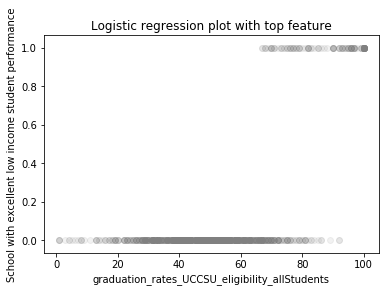

In [1162]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 4), sharey=True)
ax1.scatter(df_state_info_gs_census['graduation_rates_UCCSU_eligibility_allStudents'],
           df_state_info_gs_census['target_cat_2classes_encoded'],
           c='gray', alpha=0.1)
ax1.set_title('Logistic regression plot with top feature')
ax1.set_ylabel('School with excellent low income student performance')
ax1.set_xlabel('graduation_rates_UCCSU_eligibility_allStudents');


In [1143]:
df_temp_coef[col_teacher_ratings].T

,good-exceptional
students_per_teacher,0.00000
students_per_counselor,0.00000
pct_teachers_3years_or_more,0.00000
pct_teachers_who_r_certified,0.00000
avg_teacher_salary,0.17324


In [1142]:
df_temp_coef[col_school_info_magnet_charter].T

,good-exceptional
Magnet_cat_encoded,-0.034454
Charter_cat_encoded,0.000000


## Conclusion and summary

This project identified features that are associated with low income student success. Some features have varying degrees of "actionability": some can be affected directly by policy changes, while others could be indirectly related.

For example, it is clear that schools where all students perform well (by college eligibility rates) is a significantly good predictor in how well their low income students are also doing. Superficially, it is not completely surprising, but it highlights how the right environment benefits all demographics of students.

Other features are not as influential but indicate that some public programs reap benefits. Communities where low income students do well receive some welfare benefits (in the form of supplemental and social security income) and have workers that use public transportation. Therefore policies that adversely affect the recipients of these programs might indirectly be detrimental to the school performance of their children or grandchildren.

It is also notable what features did *not* show benefits for low income student performance. While teacher salary was positively correlated with student performance, student-to-teacher ratio or whether teachers had 3 or more years of experience were not features that predicted whether a school was exceptionally performing. The magnet or charter status of a school were also not predictive features despite their perception. Of course, adding data from other states or evaluating schools longitudinally would help inform how robust these conclusions are.

New data would also be informative. For example, recently (October 2019) the state of [California will start mandating later high school start times](https://www.washingtonpost.com/opinions/students-need-more-sleep-good-for-california-for-giving-them-a-later-school-start/2019/10/18/f5dfc0d2-f047-11e9-8693-f487e46784aa_story.html). While the sleep benefits to students are clear, it is debatable whether this could disproportionately affect low income communities.

Other interesting data would be seeing whether and how much tech usage could be impactful. Do the schools encourage teachers and students to reference Khan Academy as lesson supplements? Or do they use Remind to facilitate communication?